# Convolutional NSM
Demonstrating non-negative similarity matching with convolutional encoder.

In [1]:
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
import torch.utils.data
from torch import nn
from torchvision import datasets, transforms
from sklearn.linear_model import SGDClassifier

from pynsm import SimilarityMatching, extract_embeddings

## Load dataset and create data loaders
Using standard `torchvision` calls to load the dataset.

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)
test_data = datasets.MNIST(
    root="data", train=False, download=True, transform=transform
)
classes = [str(i) for i in range(10)]

Create training and test data loaders.

In [3]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)

Show sample images to test the loading process.

batch min=0, mean=0.136, max=1


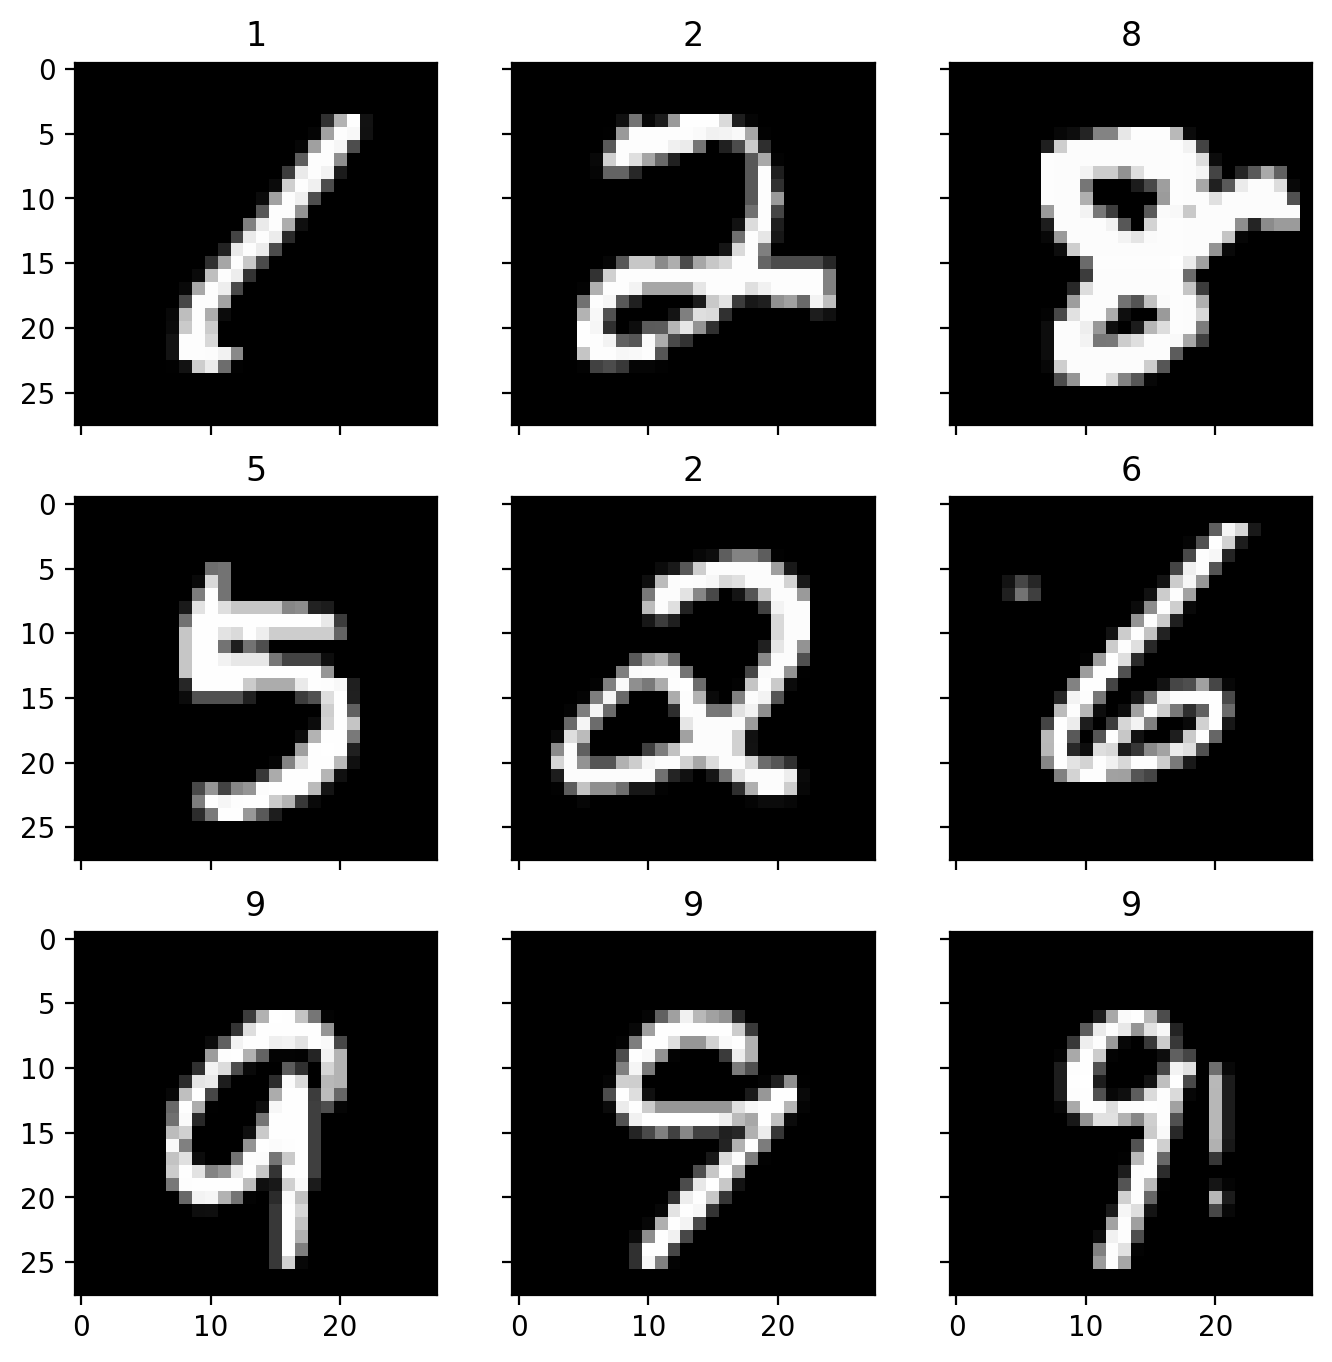

In [4]:
torch.manual_seed(42)

X_batch, y_batch = next(iter(train_loader))
X_max = X_batch.max()
X_min = X_batch.min()

print(f"batch min={X_min:.3g}, mean={X_batch.mean():.3g}, max={X_max:.3g}")

# create a grid of 3x3 images
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8, 8))
for i in range(3):
    for j in range(3):
        batch_idx = i * 3 + j
        crt_X = X_batch[batch_idx]
        ax[i][j].imshow(crt_X.numpy().squeeze(), vmin=X_min, vmax=X_max, cmap="gray")
        ax[i][j].set_title(classes[y_batch[batch_idx].item()])

## Train convolutional NSM

In [5]:
torch.manual_seed(42)
n_epochs = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

# the encoder layer is convolutional
encoder = nn.Conv2d(1, 50, 6, stride=1, padding=0, bias=False)
model = SimilarityMatching(
    encoder, out_channels=50, iteration_projection=nn.ReLU()
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

t0 = time.time()
running_loss = []
for epoch in range(n_epochs):
    pbar = tqdm(train_loader, desc=f"epoch {epoch + 1} / {n_epochs}")
    sample = 0
    for idx, data in enumerate(pbar):
        images, _ = data

        images = images.to(device)

        outputs = model(images)
        loss = model.loss(images, outputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        pbar.set_postfix({"sample": sample, "loss": running_loss[-1]}, refresh=False)

        sample += len(images)

t1 = time.time()
print(f"Training took {t1 - t0:.2f} seconds.")

Running on cpu.


epoch 3 / 3: 100%|██████████| 600/600 [01:48<00:00,  5.51it/s, sample=59900, loss=-.144]

Training took 320.97 seconds.


Show learning curves.

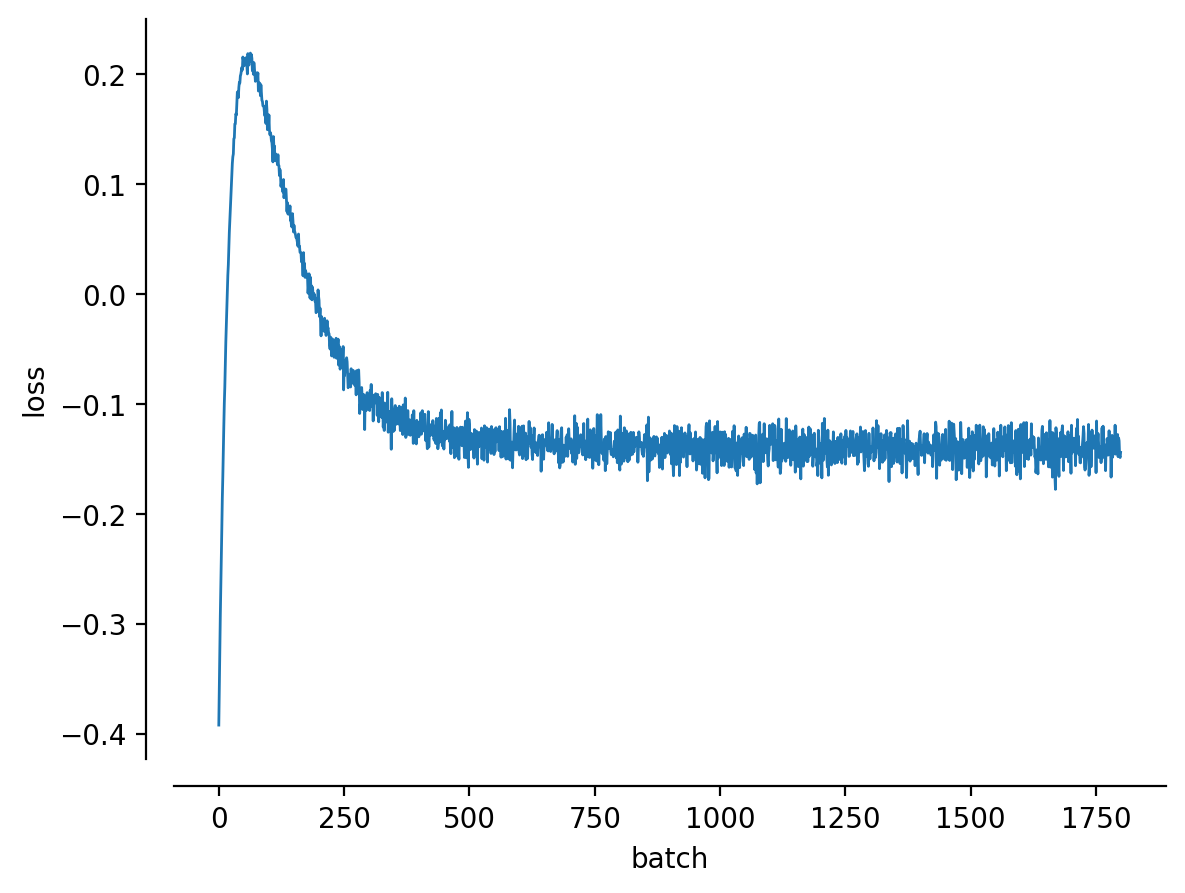

In [6]:
fig, ax = plt.subplots()
ax.plot(running_loss, lw=1.0)
ax.set_xlabel("batch")
ax.set_ylabel("loss")
sns.despine(ax=ax, offset=10)

Showcase some of the convolutional filters.

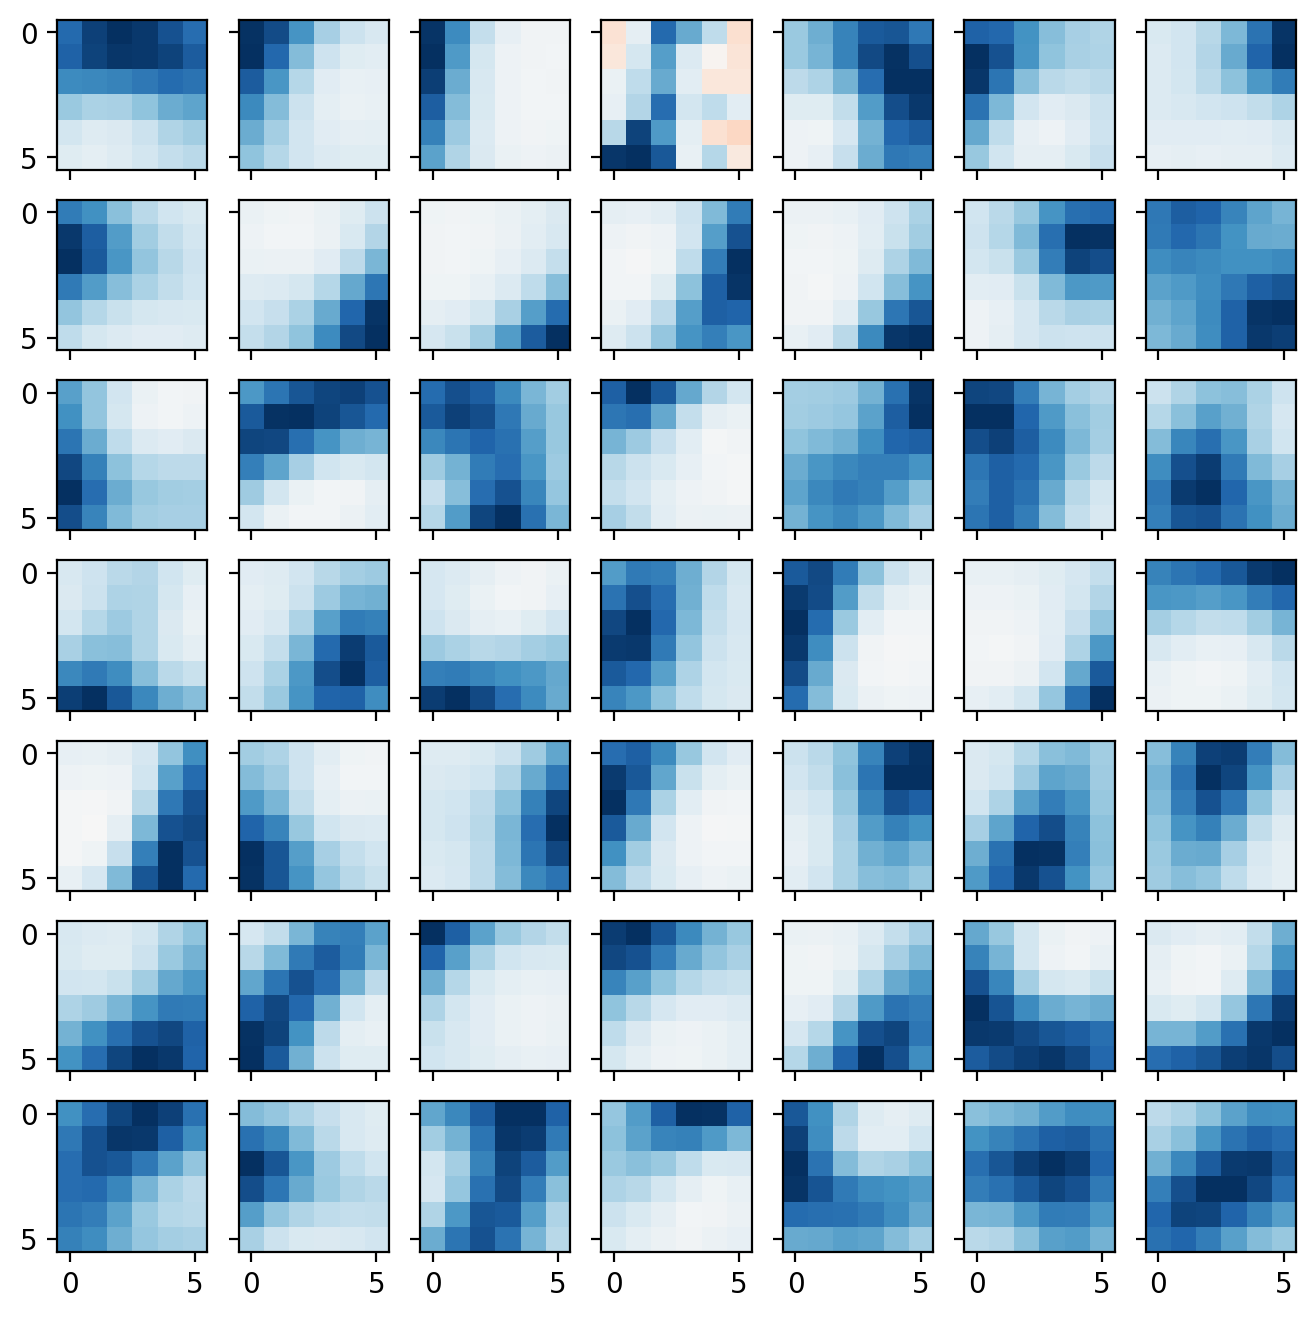

In [7]:
filters = model.encoder.weight.detach().cpu().numpy()  # type: ignore

fig, ax = plt.subplots(7, 7, sharex=True, sharey=True, figsize=(8, 8))
for i in range(7):
    for j in range(7):
        crt_filter = filters[i * 7 + j, 0]
        crt_max = np.max(np.abs(crt_filter))
        ax[i][j].imshow(crt_filter, vmin=-crt_max, vmax=crt_max, cmap="RdBu")

## Test how well the pre-trained network can help with classification

We add max pooling operation to the output from our convolutional NSM module, then check how well an SVM trained on this final output manages to classify digits.

We start by extracting the embeddings.

In [8]:
inference_model = nn.Sequential(model, nn.MaxPool2d(kernel_size=2, stride=2))
t0 = time.time()
train_embed = extract_embeddings(inference_model, train_loader, progress=tqdm)
t1 = time.time()
print(f"Embedding training set took {t1 - t0:.2f} seconds.")

t0 = time.time()
test_embed = extract_embeddings(inference_model, test_loader, progress=tqdm)
t1 = time.time()
print(f"Embedding test set took {t1 - t0:.2f} seconds.")

100%|██████████| 600/600 [01:34<00:00,  6.36it/s]


Embedding training set took 94.52 seconds.


100%|██████████| 100/100 [00:15<00:00,  6.37it/s]


Embedding test set took 15.79 seconds.


We use `scikit-learn` to fit an SVM to the embedded images.

In [9]:
n_train = len(train_embed.output)
n_test = len(test_embed.output)

classifier = SGDClassifier(random_state=123)

train_data = train_embed.output.reshape(n_train, -1)
classifier.fit(train_data, train_embed.label)
train_error = classifier.score(train_data, train_embed.label)
print(
    f"Accuracy on {len(train_embed.output)} training images: {100 * train_error:.1f}%."
)

test_error = classifier.score(test_embed.output.reshape(n_test, -1), test_embed.label)
print(f"Accuracy on {len(test_embed.output)} test images: {100 * test_error:.1f}%.")

Accuracy on 60000 training images: 99.3%.
Accuracy on 10000 test images: 98.4%.
